SELECTIVE SAPCE PCE

In [72]:
import itertools
import math
import numpy as np
import UQpy
from scipy.special import comb
from UQpy.distributions import Uniform,Normal, JointIndependent
from UQpy.surrogates.polynomial_chaos import TotalDegreeBasis, LeastSquareRegression
from UQpy.sensitivity import PceSensitivity
from UQpy.sampling import MonteCarloSampling
from sklearn.metrics import mean_squared_error, r2_score
import time  
import scipy as sp
import random
import matplotlib.pyplot as plt

import SAPCE

In [73]:
def root_mean_squared_error(y_true, y_pred, multioutput='uniform_average'):
    mse = mean_squared_error(y_true, y_pred, multioutput=multioutput)
    if isinstance(mse, np.ndarray):
        return np.sqrt(mse)
    return np.sqrt(mse)


In [74]:
import pandas as pd
data = pd.read_csv('Oakwood.csv', sep=';', header=0)
data_NVM= pd.read_csv('Oakwood_NVM.csv', sep=';', header=0)

names=data.columns.tolist()
data_array=data.to_numpy()

names_NVM=data_NVM.columns.tolist()
data_array_NVM=data_NVM.to_numpy()

In [75]:
X=data_array[:,:12]
Y_all=data_array[:,12:]
Y_tunnel=data_array[:,12:23]
Y_surface=data_array[:,23:]

Y_all_NVM=data_array_NVM[:,12:]

Y_N=Y_all_NVM[:,:113]
Y_V=Y_all_NVM[:,113:226]
Y_M=Y_all_NVM[:,226:]

In [76]:
Y_all.shape

(1000, 23)

In [77]:
# Concrete parameters
dist_Ec=Normal(13,1)
dist_Relax=Uniform(30,40)

# Soil1
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(65,5)
dist_S1_c=Normal(30,5)
dist_S1_theta=Normal(30,1)
dist_S1_ko=Uniform(0.6,0.5)

# Soil2
dist_S1_Erel=Uniform(2,1)
dist_S1_E50=Normal(130,10)
dist_S1_c=Normal(5,1)
dist_S1_theta=Normal(42,1)
dist_S1_ko=Uniform(0.45,0.2)


marg = [dist_Ec,dist_Relax, dist_S1_Erel, dist_S1_E50, dist_S1_c,dist_S1_theta,dist_S1_ko,dist_S1_Erel,dist_S1_E50,dist_S1_c,dist_S1_theta,dist_S1_ko]
joint = JointIndependent(marginals=marg)

Enter 1 to show added design points during adaptation, otherwise press Enter:  


0
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1100.5025563930553
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1100.5025563930553
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1010.841975308636
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1228.0903021655067
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1093.3841898340675
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1093.3841898340675
Adaptive basis construction terminated: basis cardinality reached experimental design size.
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1359.2017639658206
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1377.2656502472407
Adaptive basis construction terminated: des

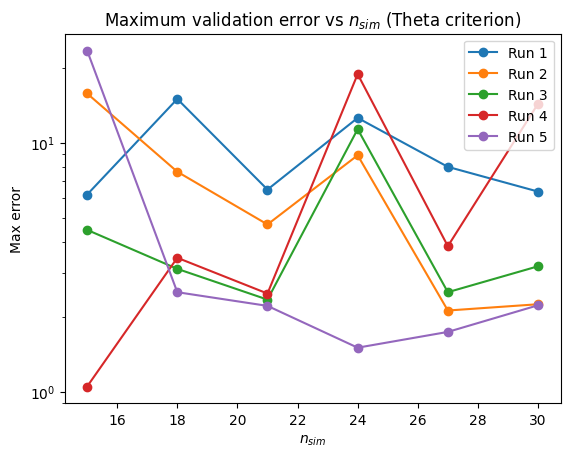

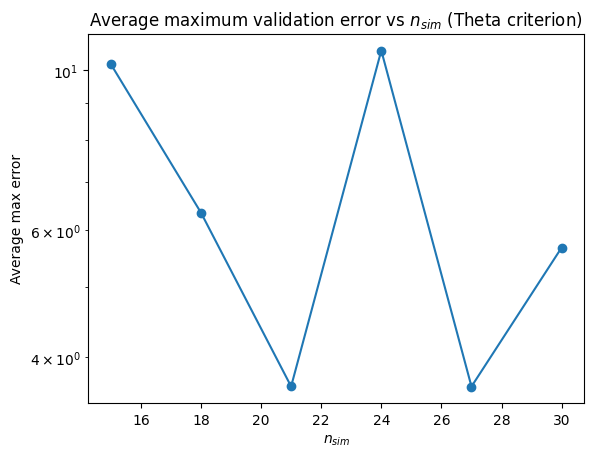

In [141]:
import numpy as np  # knihovna numpy
import matplotlib.pyplot as plt  # grafy plt
import random  # nahodne volby
from UQpy.sampling import ThetaCriterionPCE  # theta kriterium

show_design_plots = input("Enter 1 to show added design points during adaptation, otherwise press Enter: ").strip() == "1"  # volba vykresleni

errs_stat = []  # chyby behu
nsim_values = None

all_indices = np.arange(len(Y_all))  # vsechny indexy
base_n = 15
max_n = 30
increment = 3
n_steps = (max_n - base_n) // increment + 1  # pocet kroku
initial_indices_runs = [random.sample(list(all_indices), base_n) for _ in range(5)]  # start behu

for s in range(5):  # smycka behu
    print(s)
    errs = []
    nsim = []

    initial_indices = initial_indices_runs[s]  # pocatecni body
    remaining_indices = [idx for idx in all_indices if idx not in initial_indices]

    Xadapted = X[initial_indices, :]  # trenovaci X
    Yadapted = Y_all[initial_indices, :]  # trenovaci Y
    train_indices = list(initial_indices)

    for k in range(n_steps):  # smycka kroku
        n_new_this_step = 0

        if k > 0:
            for _ in range(increment):
                if not remaining_indices:
                    break
                if Xadapted.shape[0] >= max_n:
                    break

                sapce = SAPCE.SensitivityAdaptivePCE(  # vytvoreni sapce
                    pdf=joint,
                    exp_design_in=Xadapted,
                    exp_design_out=Yadapted,
                    max_partial_degree=8,
                    num_inputs=12,
                )
                sapce.construct_adaptive_basis(max_condition_number=1e3)  # baze pce
                sapce.construct_pruned_pce(cr=1e-8)  # prorezani pce

                X_candidates = X[remaining_indices, :]  # kandidati X

                ThetaSampling = ThetaCriterionPCE([sapce.pce])  # theta objekt
                pos = ThetaSampling.run(Xadapted, X_candidates)  # vyber bodu

                new_idx = remaining_indices[int(pos)]

                Xadapted = np.vstack([Xadapted, X[new_idx, :]])
                Yadapted = np.vstack([Yadapted, Y_all[new_idx, :]])

                train_indices.append(new_idx)
                remaining_indices.remove(new_idx)
                n_new_this_step += 1

        n_current = Xadapted.shape[0]
        nsim.append(n_current)

        val_indices = np.array(
            [idx for idx in all_indices if idx not in train_indices],
            dtype=int
        )  # validační body

        xx_train = Xadapted
        yy_train = Yadapted

        xx_val = X[val_indices, :]
        yy_val = Y_all[val_indices, :]

        sapce = SAPCE.SensitivityAdaptivePCE(  # novy sapce
            pdf=joint,
            exp_design_in=xx_train,
            exp_design_out=yy_train,
            max_partial_degree=8,
            num_inputs=12,
        )
        sapce.construct_adaptive_basis(max_condition_number=1e3)
        sapce.construct_pruned_pce(cr=1e-8)

        val_errors = sapce.pce.validation_error(xx_val, yy_val)  # chyby validace
        max_error = np.max(val_errors)
        errs.append(max_error)

        if show_design_plots:
            fig_vis, ax_vis = plt.subplots()
            if k == 0 or n_new_this_step == 0:
                ax_vis.scatter(xx_train[:, 0], xx_train[:, 1], c="k")
            else:
                n_old = n_current - n_new_this_step
                ax_vis.scatter(xx_train[:n_old, 0], xx_train[:n_old, 1], c="k")
                ax_vis.scatter(xx_train[n_old:, 0], xx_train[n_old:, 1], c="y")
            ax_vis.set_xlabel("X1")
            ax_vis.set_ylabel("X2")
            ax_vis.set_title(f"Training design, run {s+1}, n = {n_current} (random)")
            plt.show()

    errs_stat.append(errs)
    nsim_values = nsim

nsim = nsim_values
errs_stat_array = np.array(errs_stat)  # chyby pole
errs_theta_all = errs_stat_array.copy()
nsim_theta = nsim.copy()

fig, ax = plt.subplots()  # graf behu
for s in range(errs_stat_array.shape[0]):
    ax.plot(
        nsim,
        errs_stat_array[s, :],
        marker="o",
        label=f"Run {s+1}",
    )

ax.set_yscale("log")  # log osa
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (Theta criterion)")
ax.legend()
plt.show()

max_err_all = np.mean(errs_stat_array, axis=0)  # prumer chyb

fig_avg, ax_avg = plt.subplots()  # graf prumer
ax_avg.plot(nsim, max_err_all, marker="o")
ax_avg.set_yscale("log")
ax_avg.set_ylabel("Average max error")
ax_avg.set_xlabel("$n_{sim}$")
ax_avg.set_title("Average maximum validation error vs $n_{sim}$ (Theta criterion)")
plt.show()

nsim_theta = nsim.copy()
mean_err_theta = max_err_all.copy()


Enter 1 to show added design points during adaptation, otherwise press Enter:  


0
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1200.481016781941
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1083.9627926707544
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1139.8690127142168
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 3340.900748040995
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1755.9420489060583
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1459.364382836244
1
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1438.3351826296837
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1392.5932785990892
Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 1015.7474846291205
Adaptive basis construction

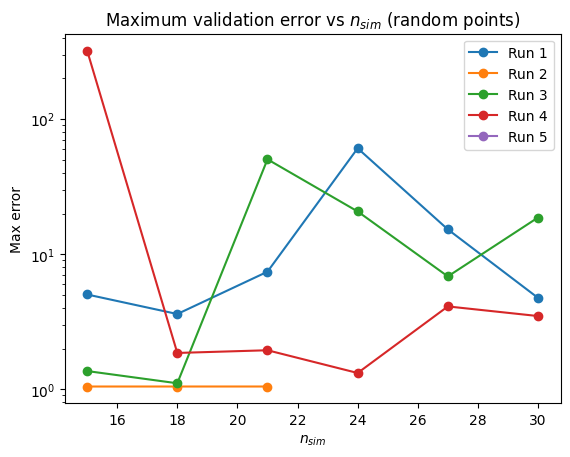

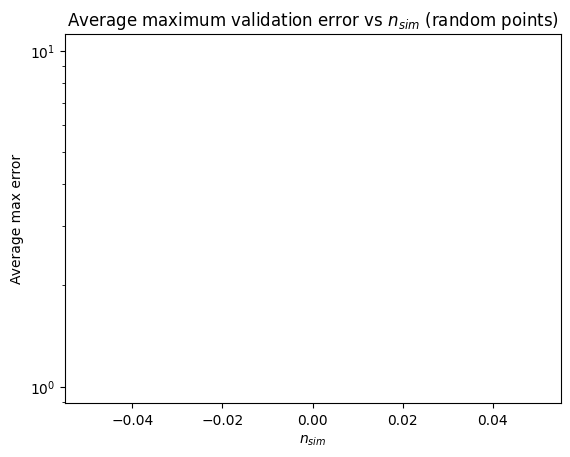

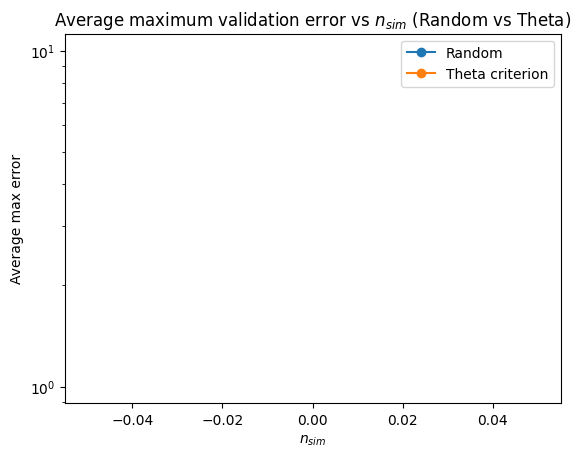

In [139]:
show_design_plots = input("Enter 1 to show added design points during adaptation, otherwise press Enter: ").strip() == "1"  # volba vykresleni

errs_stat = []  # chyby behu
nsim_values = None  # pocty simulaci

for s in range(5):  # smycka behu
    print(s)
    errs = []  # chyby behu
    nsim = []  # ulozeni nsim

    base_n = 15  # pocatecni body
    max_n = 30  # maximalni body
    increment = 3  # krok pridani
    n_steps = (max_n - base_n) // increment + 1  # pocet kroku

    initial_indices = initial_indices_runs[s]  # startovaci indexy
    remaining_indices = [idx for idx in all_indices if idx not in initial_indices]  # zbyvajici body

    train_indices = list(initial_indices)  # trenovaci indexy

    for k in range(n_steps):  # smycka kroku
        new_indices_this_step = []  # nove indexy

        if k > 0:  # od druheho kroku
            for _ in range(increment):  # pridani bodu
                if not remaining_indices:
                    break
                if len(train_indices) >= max_n:
                    break

                new_idx = random.choice(remaining_indices)  # nahodny bod
                train_indices.append(new_idx)  # pridat trenink
                remaining_indices.remove(new_idx)  # odebrat zbyvajici
                new_indices_this_step.append(new_idx)  # ulozit nove

        train_indices_array = np.array(train_indices, dtype=int)  # indexy numpy
        n_current = len(train_indices_array)  # aktualni pocet
        nsim.append(n_current)  # ulozit nsim

        val_indices = np.array(
            [idx for idx in all_indices if idx not in train_indices_array],
            dtype=int
        )  # validační body

        xx_train = X[train_indices_array, :]  # trenovaci vstupy
        yy_train = Y_all[train_indices_array, :]  # trenovaci vystupy

        xx_val = X[val_indices, :]  # validacni vstupy
        yy_val = Y_all[val_indices, :]  # validacni vystupy

        sapce = SAPCE.SensitivityAdaptivePCE(  # vytvoreni sapce
            pdf=joint,
            exp_design_in=xx_train,
            exp_design_out=yy_train,
            max_partial_degree=10,
            num_inputs=8,
        )
        sapce.construct_adaptive_basis(max_condition_number=1e3)  # adaptivni baze
        sapce.construct_pruned_pce(cr=1e-8)  # prorezani pce

        val_errors = sapce.pce.validation_error(xx_val, yy_val)  # chyby validace
        max_error = np.max(val_errors)  # maximalni chyba
        errs.append(max_error)  # ulozit chybu

        if show_design_plots and k % 1 == 0:  # pripadne kresleni
            fig_vis, ax_vis = plt.subplots()  # nova figura

            if k == 0 or len(new_indices_this_step) == 0:
                ax_vis.scatter(xx_train[:, 0], xx_train[:, 1], c="k")  # vsechny body
            else:
                n_old = n_current - len(new_indices_this_step)  # stare body pocet
                ax_vis.scatter(xx_train[:n_old, 0], xx_train[:n_old, 1], c="k")  # stare body
                ax_vis.scatter(xx_train[n_old:, 0], xx_train[n_old:, 1], c="y")  # nove body

            ax_vis.set_xlabel("X1")
            ax_vis.set_ylabel("X2")
            ax_vis.set_title(f"Training design, run {s+1}, n = {n_current} (random)")
            plt.show()

    errs_stat.append(errs)  # chyby behu
    nsim_values = nsim  # nsim behu

nsim = nsim_values  # final nsim
errs_stat_array = np.array(errs_stat)  # chyby pole
errs_random_all = errs_stat_array.copy()  # kopie random
nsim_random = nsim.copy()  # kopie nsim

fig, ax = plt.subplots()  # graf behu

for s in range(errs_stat_array.shape[0]):
    ax.plot(
        nsim,
        errs_stat_array[s, :],
        marker="o",
        label=f"Run {s+1}",
    )

ax.set_yscale("log")  # log osa
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (random points)")
ax.legend()
plt.show()

mean_err_all = np.mean(errs_stat_array, axis=0)  # prumer chyb
fig_avg, ax_avg = plt.subplots()  # graf prumeru
ax_avg.plot(nsim, mean_err_all, marker="o")
ax_avg.set_yscale("log")
ax_avg.set_ylabel("Average max error")
ax_avg.set_xlabel("$n_{sim}$")
ax_avg.set_title("Average maximum validation error vs $n_{sim}$ (random points)")
plt.show()

nsim_random = nsim.copy()  # nsim random
mean_err_random = mean_err_all.copy()  # prumer random

fig, ax = plt.subplots()  # srovnani metod
ax.plot(nsim_random, mean_err_random, marker="o", label="Random")
ax.plot(nsim_theta, mean_err_theta, marker="o", label="Theta criterion")

ax.set_yscale("log")
ax.set_ylabel("Average max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Average maximum validation error vs $n_{sim}$ (Random vs Theta)")
ax.legend()
plt.show()


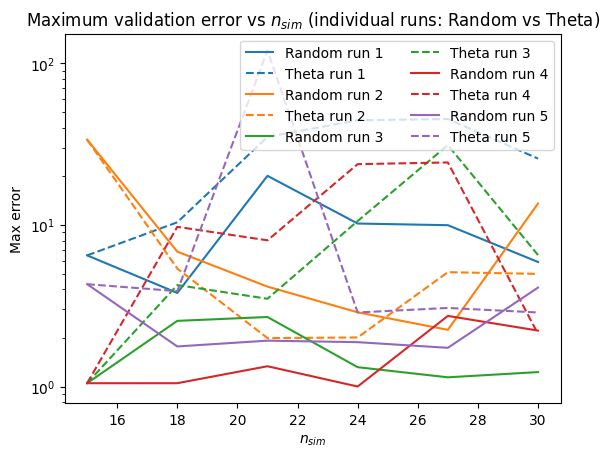

In [133]:
fig, ax = plt.subplots()

n_runs = min(errs_theta_all.shape[0], errs_random_all.shape[0])

for s in range(n_runs):
    line_random, = ax.plot(
        nsim_random,
        errs_random_all[s, :],
        linestyle="-",
        label=f"Random run {s+1}",
    )

    ax.plot(
        nsim_theta,
        errs_theta_all[s, :],
        linestyle="--",
        color=line_random.get_color(),
        label=f"Theta run {s+1}",
    )

ax.set_yscale("log")
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (individual runs: Random vs Theta)")
ax.legend(ncol=2)
plt.show()


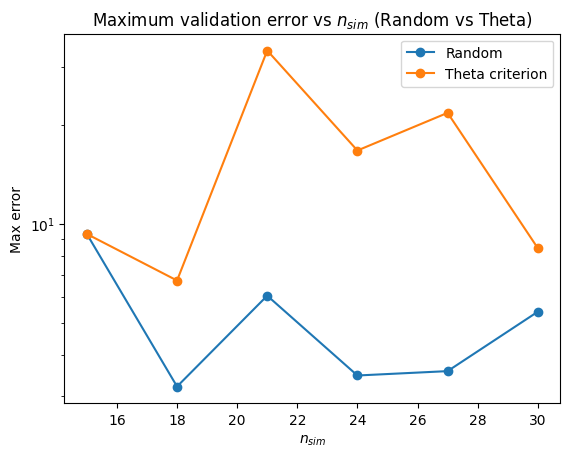

In [135]:
fig, ax = plt.subplots()
ax.plot(nsim_random, mean_err_random, marker="o", label="Random")
ax.plot(nsim_theta, mean_err_theta, marker="o", label="Theta criterion")

ax.set_yscale("log")
ax.set_ylabel("Max error")
ax.set_xlabel("$n_{sim}$")
ax.set_title("Maximum validation error vs $n_{sim}$ (Random vs Theta)")
ax.legend()
plt.show()


In [82]:
sapce.pce.coefficients

array([[ 0.00000000e+00,  2.17450464e-03, -4.03737980e-03,
        -9.52393160e-03, -4.66026743e-03, -6.97366733e-03,
        -3.69571306e-03, -9.03063650e-03, -6.17093953e-03,
        -6.91556096e-04, -1.05733975e-04, -4.46440307e-04,
         8.10282610e-06, -2.98545055e-03, -1.03477445e-02,
        -1.65847506e-02, -2.44630999e-02, -2.87838140e-02,
        -2.51930126e-02, -1.82249930e-02, -1.16242352e-02,
        -3.51526189e-03, -1.69488228e-04],
       [ 0.00000000e+00,  1.85266332e-05,  9.24167080e-04,
         7.74684750e-04,  9.38734361e-04,  6.20872904e-04,
         5.04702091e-04,  3.27430848e-04,  8.38930496e-05,
         1.88471191e-04,  1.96296029e-04,  2.24680665e-04,
        -2.08279516e-04, -7.60199021e-05,  4.62078356e-04,
         7.38591833e-04,  1.13794495e-03,  1.29234005e-03,
         1.04760683e-03,  6.50204635e-04,  3.93493002e-04,
        -1.34487924e-04, -2.27335637e-04],
       [ 0.00000000e+00,  2.37512993e-05,  1.65134960e-05,
         8.40570682e-05,  1.3

In [83]:
nsim.append(200)

rand_indices=random.sample(range(len(Y_all)), nsim[-1])
xx_train=X[rand_indices,:]
yy_train=Y_all[rand_indices,:]

xx_val=np.delete(X, rand_indices)
yy_val=np.delete(Y_all, rand_indices)


sapce = SAPCE.SensitivityAdaptivePCE(pdf=joint, exp_design_in=xx_train, exp_design_out=yy_train, max_partial_degree=10, num_inputs=12)
sapce.construct_adaptive_basis(max_condition_number=1e4)
sapce.construct_pruned_pce(cr=1e-8)

Adaptive basis construction terminated: design matrix not sufficiently well-conditioned: 29834.046579074435
